# Predicting Genres from Movie Dialogue

Below is the construction process of a multi-label natural language processing (NLP) classification model designed to predict a movie's genres based on an exchange from its dialogue.

The motivation behind the project was to explore whether text patterns could be uncovered in movies' dialogue to act as indicators of their genres. A more in-depth discussion of the process of building the model can be found in a Medium post linked in the repository's README.

The data used to train the model was obtained courtesy of Cornell University and saved to a SQLite database. The Python script used to run the ETL pipeline along with the raw data files can be found in the same repository as this notebook. Acknowledgements are also listed in the repository's README.

The model's construction process will fall under three main stages:

1. Reading in and reformatting the training data
2. Undertaking exploratory analysis of the training data
3. Implementing a baseline model and tuning hyper-parameters to optimise performance

## Part I: Preparing the Training Data

Let's begin by importing the necessary libraries. These will consist of some of the usual libraries for data wrangling (such as pandas and NumPy), the Natural Language Toolkit (nltk) library for implementing NLP techniques, and scikit-learn for eventually building the machine learning model.

In [1]:
import time
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
from scipy import stats

from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harryroper/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harryroper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harryroper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can now read in the training data from the SQLite database and check how many individual exchanges we have on which to train the model.

In [2]:
engine = create_engine('sqlite:///dialogue.db')
df = pd.read_sql('dialogue', engine)
display(df.head())
print('Total # of exchanges: {}'.format(str(len(df))))

,movie_id,movie,genres,dialogue
0,m0,10 things i hate about you,"comedy,romance",Can we make this quick? Roxanne Korrine and A...
1,m0,10 things i hate about you,"comedy,romance",You're asking me out. That's so cute. What's ...
2,m0,10 things i hate about you,"comedy,romance","No, no, it's my fault -- we didn't have a prop..."
3,m0,10 things i hate about you,"comedy,romance",Why? Unsolved mystery. She used to be really ...
4,m0,10 things i hate about you,"comedy,romance","Gosh, if only we could find Kat a boyfriend......"


Total # of exchanges: 82968


To transform the data into a format suitable to be passed into a machine learning algorithm, we need to create an individual column for each unqiue genre with a binary value to indicate whether the given genre appears in the **genre** column for the instance. These columns will then act as a target variable matrix.

In [3]:
genres = df['genres'].tolist()
genres = ','.join(genres)
genres = genres.split(',')
genres = sorted(list(set(genres)))
print('Count of unique genres: {}'.format(str(len(genres))))

Count of unique genres: 24


In [4]:
for genre in genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

## Part II: Exploring the Training Data

As a first step in some exploratory analysis of the training data, let's plot the count of movies per number of genre labels to which they're assigned.

In [5]:
df['label_count'] = df[genres].sum(axis=1)
label_counts = df.groupby('label_count')['movie_id'].nunique().reset_index()
label_counts

,label_count,movie_id
0,1,69
1,2,143
2,3,209
3,4,137
4,5,50
5,6,5
6,7,1
7,8,2


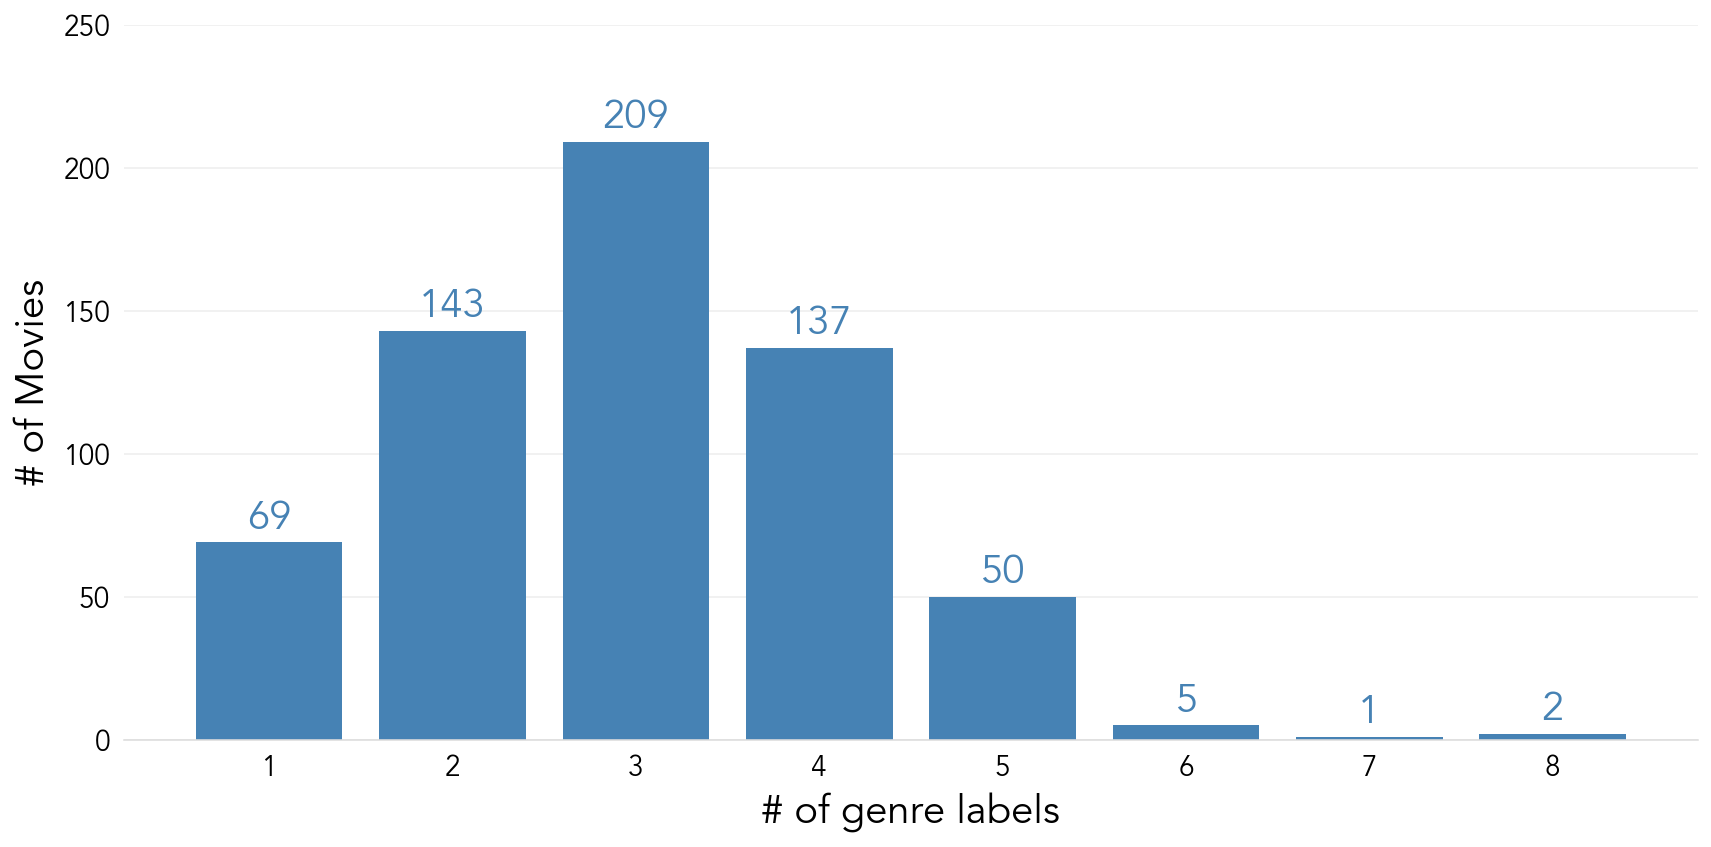

In [6]:
fig1 = plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

ax = fig1.add_subplot(1, 1, 1)
bars = ax.bar(label_counts['label_count'], label_counts['movie_id'], color='steelblue')

ax.set_xlabel('# of genre labels', fontsize=20)
ax.set_ylabel('# of Movies', fontsize=20)
ax.set_ylim(0, 250)
ax.set_xticks(label_counts['label_count'])
ax.set_xticklabels(label_counts['label_count'], fontsize=14)
ax.set_yticks(range(0, 251, 50))
ax.set_yticklabels(range(0, 251, 50), fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, bar.get_height(), \
            horizontalalignment='center', color=bar.get_facecolor(), weight='bold', fontsize=20)

plt.tight_layout()
plt.show()
fig1.savefig('movie_dialogue_labels.png')

Let's also analyse the number of positively classified exchanges present in the data set per genre label.

In [7]:
df_melt = pd.melt(df, id_vars='movie_id', value_vars=genres, var_name='genre', value_name='label')
genre_counts = df_melt.groupby('genre')['label'].sum().reset_index()
genre_counts.head()

,genre,label
0,action,19967
1,adult,88
2,adventure,13418
3,animation,1983
4,biography,3700


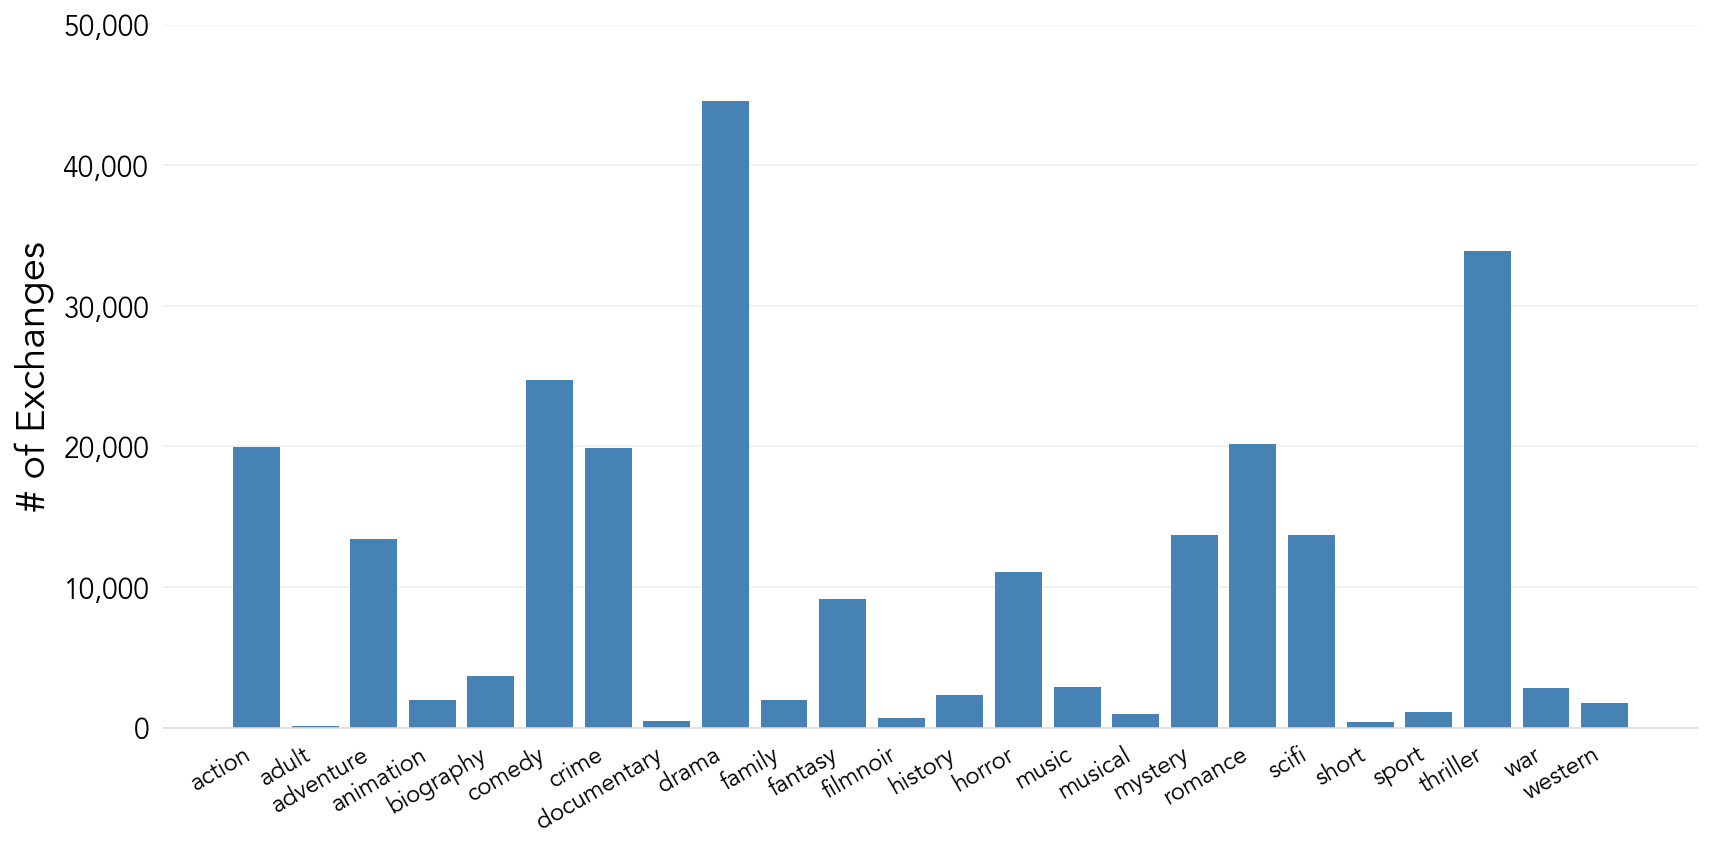

In [8]:
fig2 = plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

ax = fig2.add_subplot(1, 1, 1)
bars = ax.bar(range(len(genre_counts['genre'])), genre_counts['label'], color='steelblue')

ax.set_ylabel('# of Exchanges', fontsize=20)
ax.set_ylim(0, 50000)
ax.set_xticks(range(len(genre_counts['genre'])))
ax.set_xticklabels(genre_counts['genre'], fontsize=12, rotation=30, ha='right')
ax.set_yticks(range(0, 50001, 10000))
ax.set_yticklabels([format(i, ',') for i in range(0, 50001, 10000)], fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()
fig2.savefig('movie_dialogue_genres.png')

The exploratory analysis of the training data uncovers two key insights to be considered during the modelling stage:

1. There is a significant **class** imbalance in favour of the negative
2. There is an imbalanced distribution of positive classes across **labels**

## Part III: Building the Classification Model

We'll start the modelling process by defining the feature (X) and target (y) variables.

The target variable will be the matrix of genre columns, which we've already transformed into the suitable binary format.

For now, the feature variables will be the **dialogue** column. We'll need to transform the text documents into a numerical feature matrix before we can pass them into an algorithm

Once we've defined an X and y, we'll perform a train test split so that we can validate the model at a later stage.

In [9]:
X = df['dialogue']
y = df[genres]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Before we can create the feature variable matrix, we'll need to define a function to clean and tokenise the text documents. This will make use of the nltk library to remove punctuation and special characters, split the words in each document into a list of tokens, lemmatise the tokens, remove whitespace, set to lower case, and finally filter out stop words.

In [10]:
def tokenize(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = (lemmatizer.lemmatize(token).lower().strip() for token in tokens if token \
                    not in stopwords.words('english'))
    return clean_tokens

The next stages of the NLP transformation will be to vectorise documents into word counts, and finally employ a term frequency-inverse document frequency (TFIDF) transformation to smoothen counts based on the frequency of terms in the corpus.

In order to prevent either data leakage from applying the transormations to the entire data set or cumbrousness from having to repeat the process on training and testing data separately, we can incorporate all the NLP stages into a single pipeline. The pipeline can then culminate in fitting the classification algorithm on the data.

As an initial baseline model, we'll pass in a decision tree as the pipeline's estimator. Since this is a multi-label classification problem, we'll also need to specify that the estimator should be a multi-output classifier.

In [11]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

Once we've defined the pipeline for the baseline model, we can run some scoring metrics to evaluate initial performance.

In [12]:
pipeline.fit(X_train, y_train)
print('Training complete.')

Training complete.


In [13]:
y_pred = pd.DataFrame(pipeline.predict(X_test), columns=genres)

In [14]:
1 - hamming_loss(y_test, y_pred)

0.8667440038568157

In [15]:
precision_score(y_test, y_pred, average='weighted')

0.44485346325188513

In [16]:
recall_score(y_test, y_pred, average='weighted')

0.39102002566871064

In [17]:
f1_score(y_test, y_pred, average='weighted')

0.41478130331069335

Due to the previously identified class imbalance, we can ascertain that an accuracy score (such as the Hamming loss subtracted from one) will provide an overly generous assessment of performance. Since precision and recall are more appropriate measures in this context, we'll use the F1 score (the harmonic mean between the two) as the overarching metric for the model.

Since this is a multi-label classification problem, we can specify within the metric functions that the score returned should be the average across labels weighted on each label's number of positive classes.

We also identified an imbalance across labels. Let's analyse the effect of this by plotting the F1 score for each individual genre against the number of training documents for which it is classified positively.

In [18]:
scores = []
for genre in genres:
    scores.append(f1_score(y_pred[genre], y_test[genre]))
label_scores = pd.DataFrame({'genre': genres, 'score': scores})
label_scores = label_scores.merge(genre_counts, on='genre', how='left')
r = round(stats.pearsonr(label_scores['label'], label_scores['score'])[0], 2)

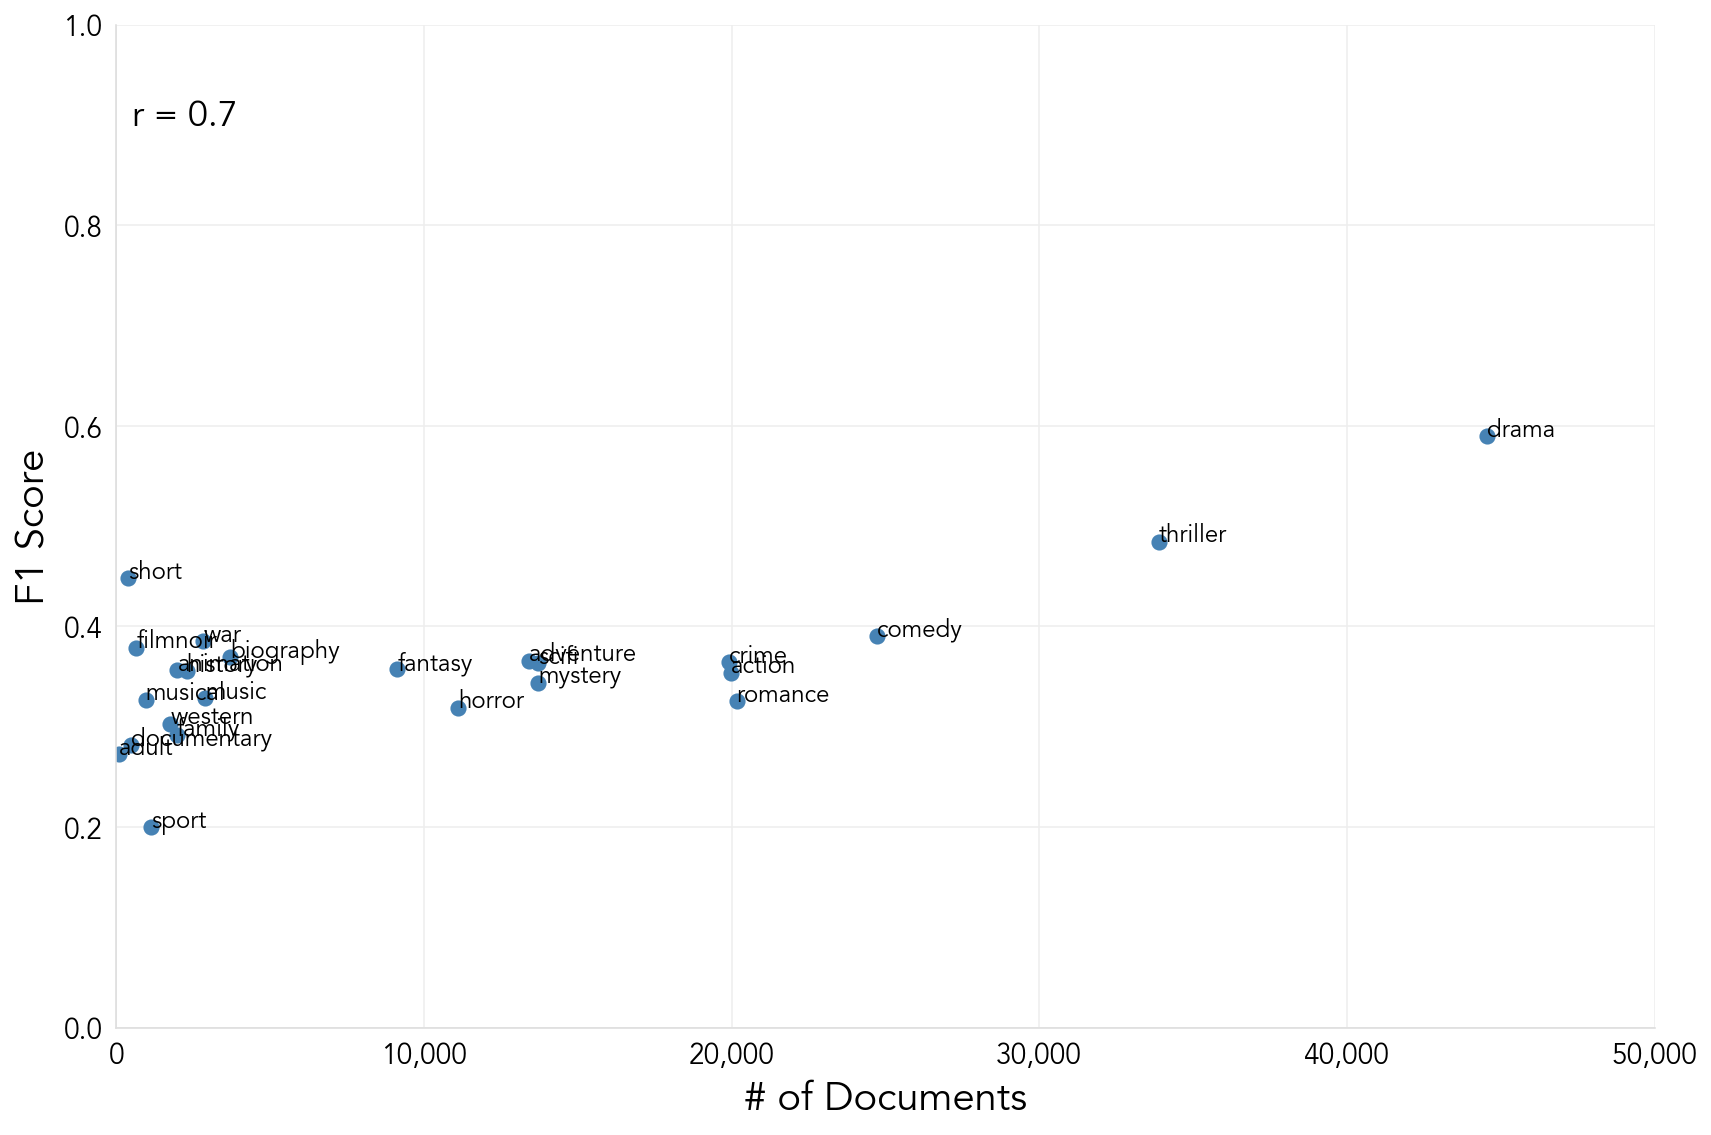

In [19]:
fig3 = plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

ax = fig3.add_subplot(1, 1, 1)
ax.scatter(label_scores['label'], label_scores['score'], color='steelblue', s=50)

ax.set_xlim(0, 50000)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, 50001, 10000))
ax.set_xticklabels([format(i, ',') for i in range(0, 50001, 10000)], fontsize=14)
ax.set_yticks([i/10 for i in range(0, 11, 2)])
ax.set_yticklabels([i/10 for i in range(0, 11, 2)], fontsize=14)
ax.set_xlabel('# of Documents', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE')

for i, genre in enumerate(genres):
    ax.annotate(genre, (label_scores['label'][i], label_scores['score'][i]), fontsize=12)

ax.text(500, 0.9, 'r = ' + str(r), fontsize=18)

plt.tight_layout()
plt.show()
fig3.savefig('movie_dialogue_scores.png')

Now that we've established a baseline model, let's attempt to improve performance.

We can first test some other classification algorithms to determine which produces the best results on the training data.

We should switch from evaluating the model over a single training and testing split to using the average score from a cross validation, since this will give a more robust measure of performance.

An additional step will also be added to the pipeline: singular value decomposition. This will reduce the dimensionality of the feature variable matrix and hopefully improve computational runtime.

In [20]:
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
knn = KNeighborsClassifier()

models = [tree, forest, knn]
model_names = ['tree', 'forest', 'knn']

In [21]:
start_time = time.time()
scores = []

for model in models:
    pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD()),
    ('clf', MultiOutputClassifier(model))
    ])
    cv_scores = cross_val_score(pipeline, X, y, scoring='f1_weighted', cv=4, n_jobs=-1)
    score = round(np.mean(cv_scores), 4)
    scores.append(score)

model_compare = pd.DataFrame({'model': model_names, 'score': scores})
display(model_compare)
print('Time elapsed:')
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))

,model,score
0,tree,0.2930
1,forest,0.2274
2,knn,0.2284


Time elapsed:
00:52:09


Since the decision tree scored the best of all the models tested, we'll stick with this as our estimator.

The final stage in optimising the model is to tune the hyper-parameters. This applies both to the estimator and to other stages of the pipeline, such as the vectoriser.

To find the optimal combination of paramters, we can run a cross validation grid search, and output the final paramters and score for the best model.

In [25]:
start_time = time.time()

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
    ])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__estimator__max_depth': [250, 500, 1000],
    'clf__estimator__min_samples_split': [1, 2, 6]
}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1_weighted', cv=4, n_jobs=-1, verbose=10)
cv.fit(X, y)
print('GridSearch complete.')
print('Best params:')
print(cv.best_params_)
print('Best score:')
print(cv.best_score_)
print('Time elapsed:')
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))

Fitting 4 folds for each of 18 candidates, totalling 72 fits
GridSearch complete.
Best params:
{'clf__estimator__max_depth': 500, 'clf__estimator__min_samples_split': 2, 'vect__ngram_range': (1, 1)}
Best score:
0.29404722954784424
Time elapsed:
02:16:43


Now that we've tuned the paramters to find the optimal model, we can test it out on a couple of lines from movies that weren't included in the training set to observe the classifier in action.

In [26]:
def predict_genres(text):
    pred = pd.DataFrame(cv.predict([text]), columns=genres)
    pred = pred.transpose().reset_index()
    pred.columns = ['genre', 'prediction']
    predictions = pred[pred['prediction']==1]['genre'].tolist()
    return predictions

In [27]:
line1 = "If god did not exist it would be necessary to invent him."
line2 = "It's funny... the world is so different in the daylight. In the dark, your fantasies get so out of hand. \
But in the daylight everything falls back into place again."
print('Line 1: {}'.format(predict_genres(line1)))
print('Line 2: {}'.format(predict_genres(line2)))

Line 1: ['action', 'comedy', 'drama', 'romance']
Line 2: ['family', 'scifi', 'thriller']
